## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [46]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [47]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [48]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [49]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [50]:
len(fmnist_dataset_test)

10000

In [51]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [52]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):     
        out = self.model(inp)
        return out

In [53]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                   [-1, 10]           7,850
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.38
Estimated Total Size (MB): 2.40
----------------------------------------------------------------


Your experiments come here:

'\nСлева грфик ошибки на трейне, справа на тесте на каждой эпохе обучения. \nКак видно, на обоих графиках ошибка падает с течением обучения, значит все ок.\n'

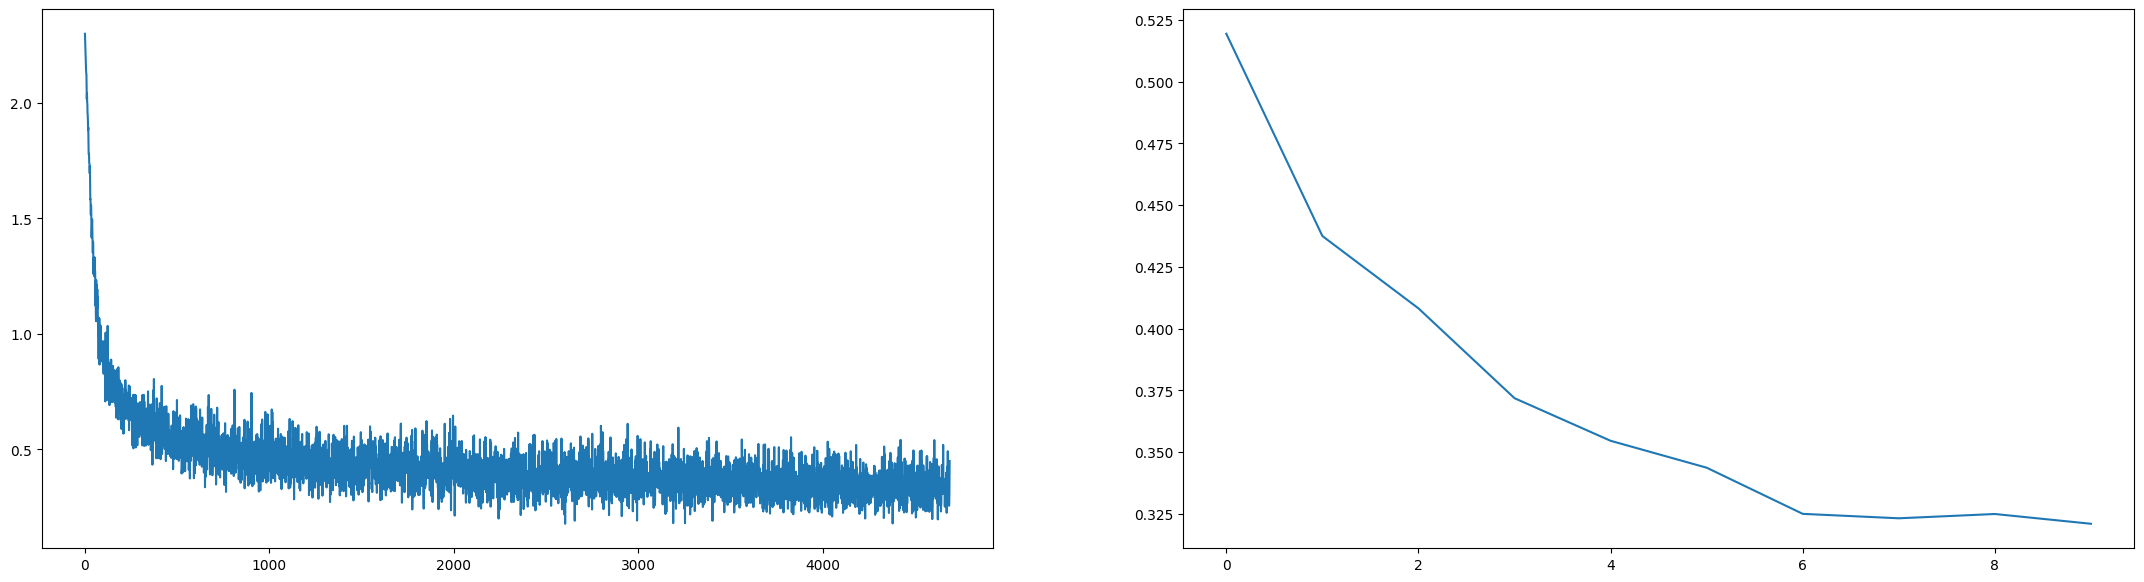

In [54]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)

#! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
train_loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения
test_loss_history = []

for i in range(epochs):
    for images_batch, lables_batch in train_loader:    
        # делаем предсказание модели
        prediction = model(images_batch)
        # считаем значение функции потерь
        loss = loss_func(prediction, lables_batch)
        
        #! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
        train_loss_history.append(loss.item())

        # вычисляем градиенты
        opt.zero_grad()
        loss.backward()

        # делаем шаг градиентного спуска
        opt.step()

    for img, label in test_loader:
        prediction = model(img)
        # считаем значение функции потерь
        test_loss = loss_func(prediction, label)
        
        #! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
        test_loss_history.append(test_loss.item())
        break

#! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
plt.figure(figsize=(27, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.subplot(1, 2, 2)
plt.plot(range(len(test_loss_history)), test_loss_history)
'''
Слева грфик ошибки на трейне, справа на тесте на каждой эпохе обучения. 
Как видно, на обоих графиках ошибка падает с течением обучения, значит все ок.
'''

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [55]:
'''
Потенциальные причины переобучения сети:
1) большая глубина сети
2) большое количество нейронов
3) мало данных (малый размер батча)
'''

class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [56]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
              ReLU-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
              ReLU-7                  [-1, 784]               0
            Linear-8                  [-1, 784]         615,440
              ReLU-9                  [-1, 784]               0
           Linear-10                  [-1, 784]         615,440
             ReLU-11                  [-1, 784]               0
           Linear-12                  [-1, 784]         615,440
             ReLU-13                  [-1, 784]               0
           Linear-14                  [

In [58]:
'''
Я уменьшаю размер батча, чтобы искусственно ввести переобучение
'''

train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=2)

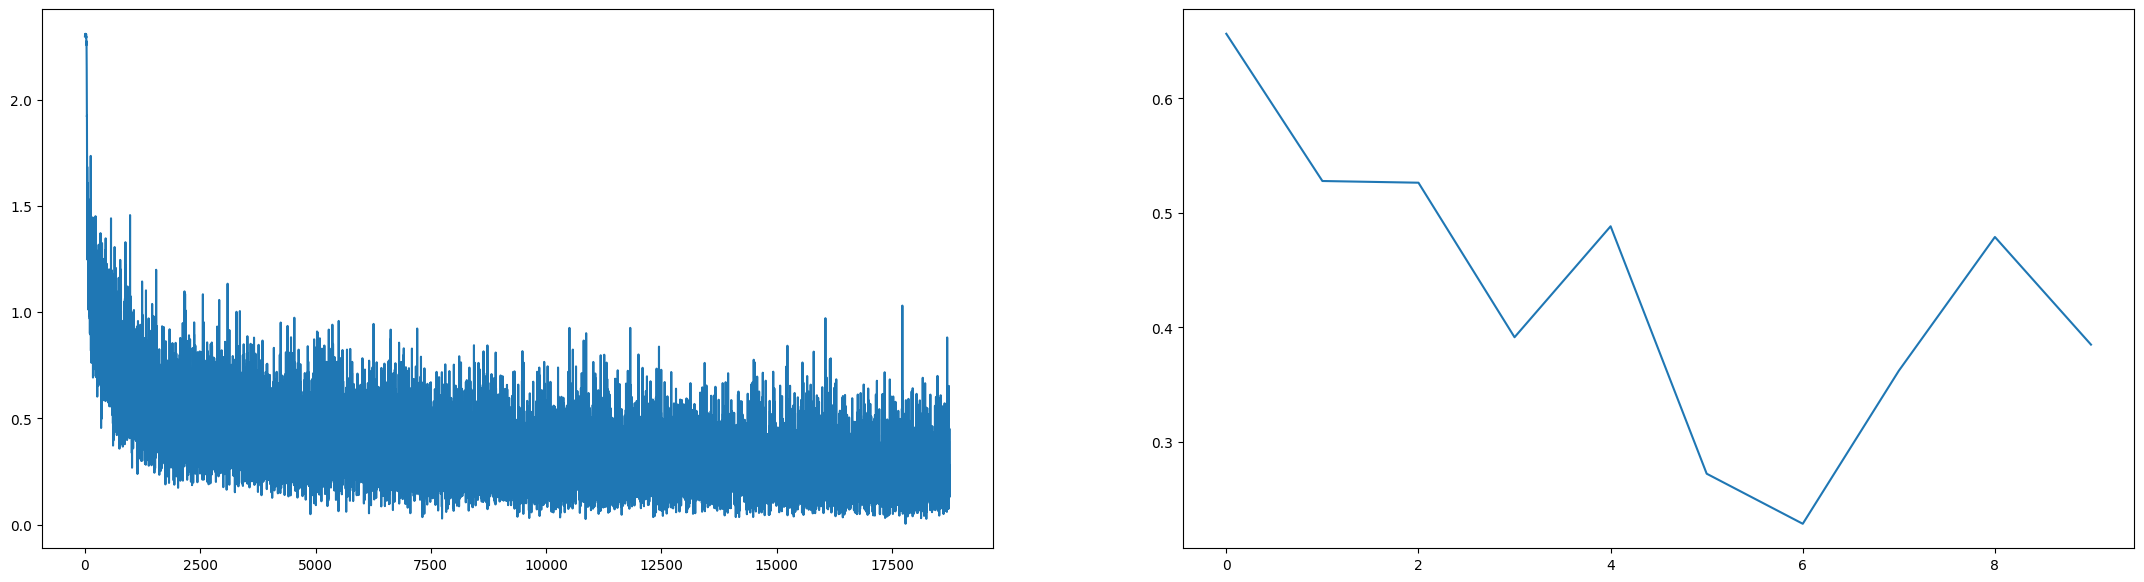

In [59]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)

#! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
train_loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения
test_loss_history = []

for i in range(epochs):
    for images_batch, lables_batch in train_loader:    
        # делаем предсказание модели
        prediction = model(images_batch)
        # считаем значение функции потерь
        loss = loss_func(prediction, lables_batch)
        
        #! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
        train_loss_history.append(loss.item())

        # вычисляем градиенты
        opt.zero_grad()
        loss.backward()

        # делаем шаг градиентного спуска
        opt.step()

    for img, label in test_loader:
        prediction = model(img)
        # считаем значение функции потерь
        test_loss = loss_func(prediction, label)
        
        #! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
        test_loss_history.append(test_loss.item())
        break

#! раскомментируйте эту строчку, чтобы посмотреть график изменения ошибки в процессе обучения
plt.figure(figsize=(27, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.subplot(1, 2, 2)
plt.plot(range(len(test_loss_history)), test_loss_history)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._